<big><big><big> (currently) avaliable spectra</big></big></big>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import os
import time

from astropy.modeling import models
from astropy import units as u

from specutils.spectra import Spectrum1D
from specutils.fitting import fit_lines

In [2]:
# for all objects (w/and w/o spectra)
obj_type_df = pd.read_csv('obj_type.csv')
obj_info_df = pd.read_csv('obj_info_df.csv')
obj_info_df[:1]

,obj_id,tns_id,ra,dec,ra error,dec error,host gal,gal lat,gal lon,lum distance
0,ZTF17aaaacjo,NaN,88.123064,14.443266,NaN,NaN,NaN,-6.056066,193.287491,NaN


In [3]:
spectra_type_df = pd.read_csv('spectra_data_ID.csv')
spectra_ids = spectra_type_df['obj_id'].to_list()
spectra_info_df = obj_info_df[obj_info_df['obj_id'].isin(spectra_ids)]
spectra_info_df[:1]

,obj_id,tns_id,ra,dec,ra error,dec error,host gal,gal lat,gal lon,lum distance
39,ZTF17aaajnki,NaN,186.453686,33.54698,NaN,NaN,['NGC 4395'],81.532852,162.093851,NaN


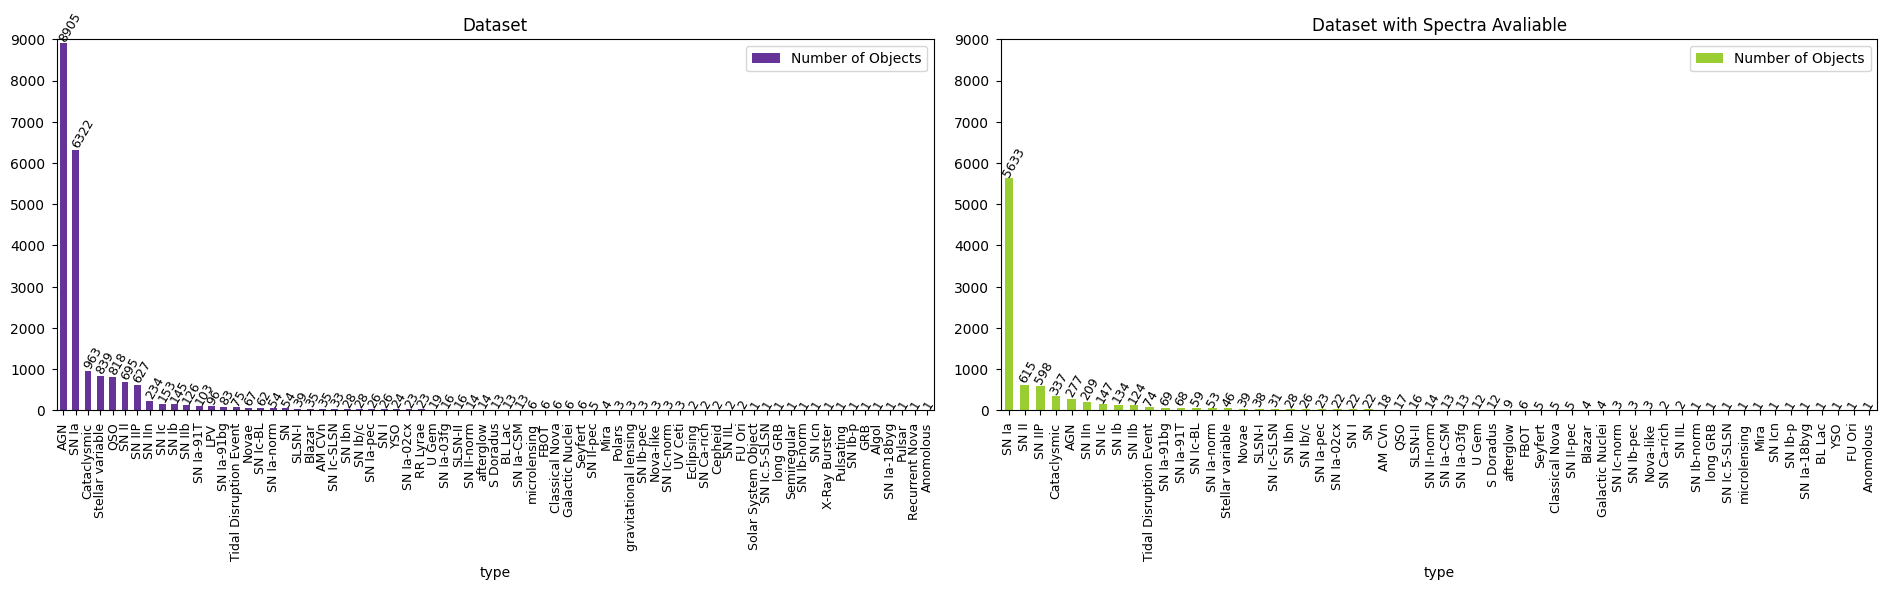

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(19, 6))

obj_type_df["type"].value_counts().plot(ax = ax[0], kind="bar", color='rebeccapurple', width=0.55, label='Number of Objects')
ax[0].set_title('Dataset')
ax[0].set_ylim(0, 9000)
ax[0].legend()
for p in ax[0].patches:
    ax[0].annotate(
        str(p.get_height()), xy=(p.get_x()-0.26, p.get_height() +60), fontsize=9,
    rotation=60)
ax[0].tick_params(axis='both', which='major', pad=5)
ax[0].tick_params(axis='x', which='major', labelsize=9)

spectra_type_df["type"].value_counts().plot(ax = ax[1], kind="bar", color='yellowgreen', width=0.55, label='Number of Objects')
ax[1].set_title('Dataset with Spectra Avaliable')
ax[1].set_ylim(0, 9000)
ax[1].set_xlabel('type')
ax[1].legend()
ax[1].tick_params(axis='both', which='major', pad=5)
ax[1].tick_params(axis='x', which='major', labelsize=9)
for p in ax[1].patches:
    ax[1].annotate(
        str(p.get_height()), xy=(p.get_x()-0.26, p.get_height() +60), fontsize=9,
    rotation=60)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [5]:
spectra_master_df = pd.read_csv('spectra_master.csv')
# since we want to know values by object/ID
spectra_data_df = spectra_master_df.drop_duplicates(subset='ZTFID', keep="first")
spectra_data_df = spectra_data_df.reset_index(drop=True)

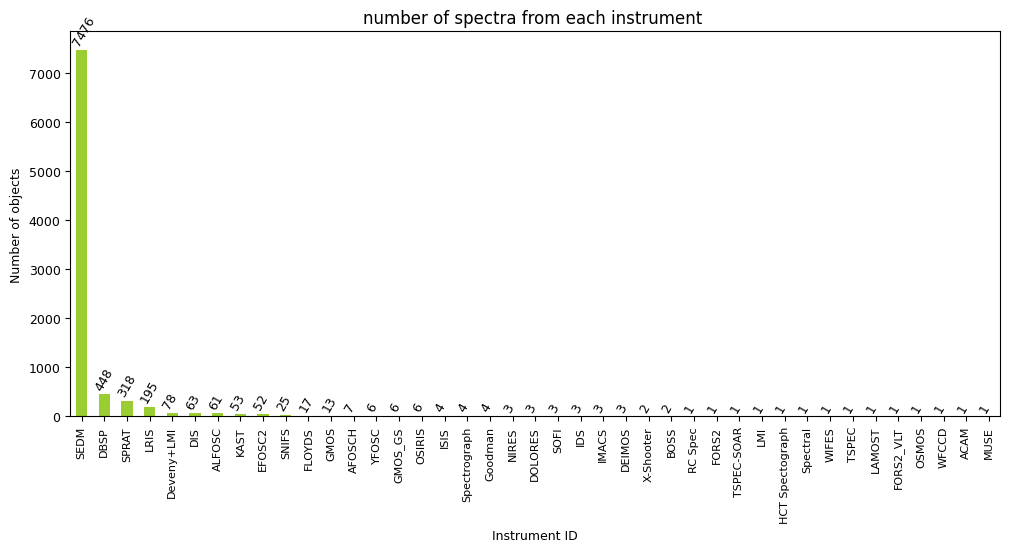

In [6]:
ax = spectra_data_df['instrument_name'].value_counts().plot(kind="bar", color="yellowgreen",figsize=[12,5], 
                                        title="number of spectra from each instrument ")
plt.xticks(rotation=90, horizontalalignment="center", fontsize=8)
plt.yticks(fontsize=9)
plt.ylabel("Number of objects", fontsize=9)
plt.xlabel("Instrument ID", fontsize=9)
for p in ax.patches:
    ax.annotate(
        str(p.get_height()), xy=(p.get_x()-0.26, p.get_height() +105), fontsize=9,
    rotation=60)
plt.show()

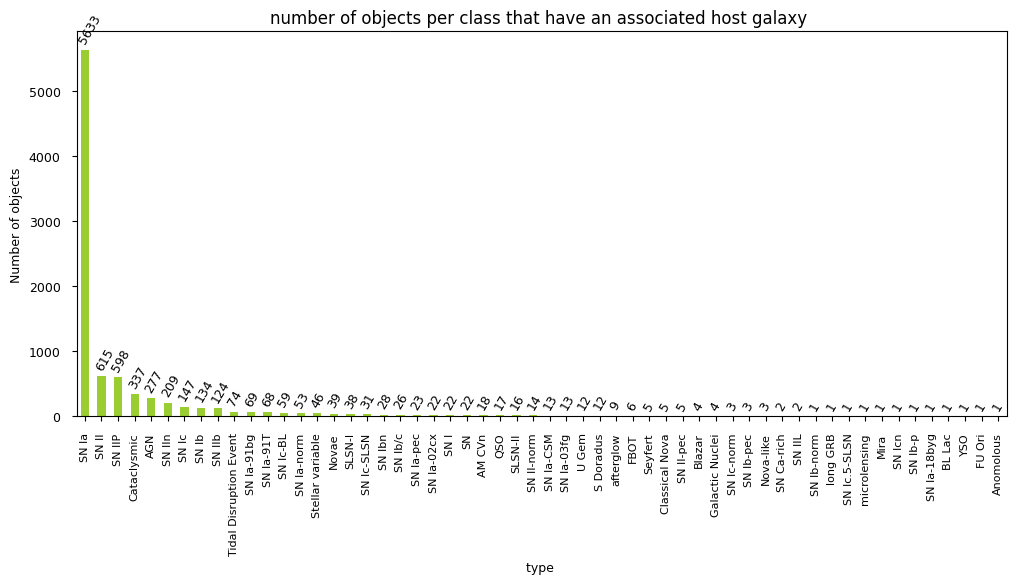

In [7]:
obj_type_host_check = obj_type_df[obj_type_df['obj_id'].isin(spectra_ids)]

ax = obj_type_host_check['type'].value_counts().plot(kind="bar", color="yellowgreen",figsize=[12,5], 
                                        title="number of objects per class that have an associated host galaxy ")
plt.xticks(rotation=90, horizontalalignment="center", fontsize=8)
plt.yticks(fontsize=9)
plt.ylabel("Number of objects", fontsize=9)
plt.xlabel("type ", fontsize=9)
for p in ax.patches:
    ax.annotate(
        str(p.get_height()), xy=(p.get_x()-0.26, p.get_height() +105), fontsize=9,
    rotation=60)
plt.tick_params(axis='both', which='major', pad=8)

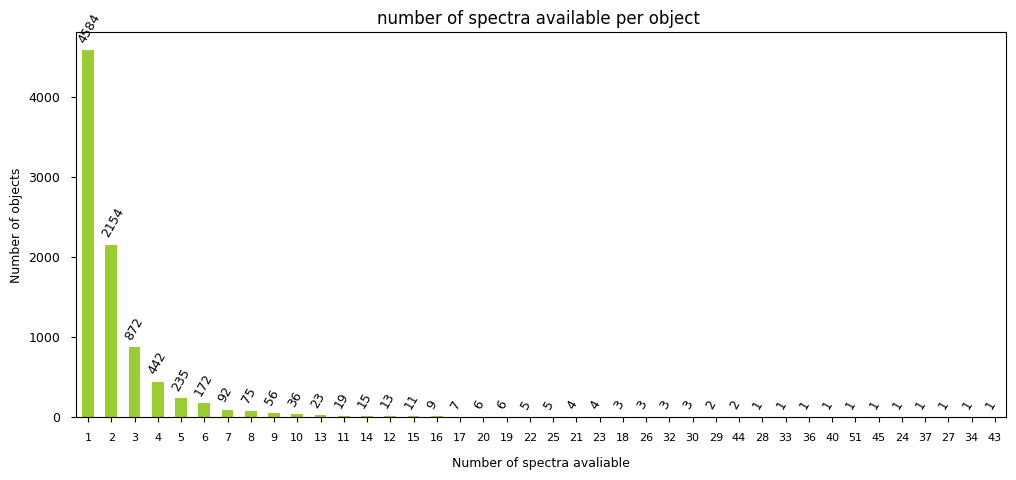

In [8]:
ax = spectra_data_df['data_length'].value_counts().plot(kind="bar", color="yellowgreen",figsize=[12,5], 
                                        title="number of spectra available per object ")
plt.xticks(rotation=0, horizontalalignment="center", fontsize=8)
plt.yticks(fontsize=9)
plt.ylabel("Number of objects", fontsize=9)
plt.xlabel("Number of spectra avaliable", fontsize=9, labelpad=10)
for p in ax.patches:
    ax.annotate(
        str(p.get_height()), xy=(p.get_x()-0.26, p.get_height() +105), fontsize=9,
    rotation=60)
plt.tick_params(axis='both', which='major', pad=8)
plt.show()

<big><big>Difference between observed date of photometry and spectra </big></big>

> this created `spectra_date_df.csv`, don't need to run again. 

In [9]:
pd.options.display.float_format = '{:.4f}'.format

class SpectraAnalysis:
    def get_photometry_date(obj_id_list):
        '''
        Parameters
        ----------
        obj_id_list : list
            list of ZTF IDs, nice if already sorted too
        Returns
        ----------
        dataframe 
            ZTF ID, first photometric observation date in photometry.csv
        '''
        photometry_date_list = []

        for obj_id in tqdm(obj_id_list, desc='Processing Objects', leave=True):
            objDirectory = os.path.join('(aj)data_all', obj_id)
            filename = 'photometry.csv'
            photo_df = pd.read_csv(os.path.join(objDirectory, filename))

            # change col name
            photo_df['ZTFID'] = photo_df['obj_id']

            # convert jd to mjd
            photo_df['mjd'] = photo_df['jd'] - 2400000.5
            photo_df['photometry_mjd'] = photo_df['mjd']
            photo_df = photo_df[['ZTFID','photometry_mjd']]
            # gets date of first point in light curve only
            get_date_df = photo_df[:1]
            # append to list
            photometry_date_list.append(get_date_df)

        return pd.concat(photometry_date_list, ignore_index=True)


    def get_date_difference_df(spectra_date_df, spectra_type_df):
        '''
        makes new dataframe with col:
        - ZTF ID
        - first photometric measurement date
        - most recent spectra data
        - difference
        - how many spectra in fritz
        '''
        photometry_date_df = SpectraAnalysis.get_photometry_date(spectra_data_df['ZTFID'].sort_values().to_list())

        # needs to be sorted by ID for row subtraction of date
        photometry_date_df = photometry_date_df.sort_values('ZTFID').reset_index(drop=True)
        spectra_date_df = spectra_date_df.sort_values('ZTFID').reset_index(drop=True)
        spectra_type_df = spectra_type_df.sort_values('obj_id').reset_index(drop=True)

        photometry_date_df['spectra_mjd'] = spectra_date_df['observed_at_mjd'] # make spectra
        photometry_date_df['delta'] = np.absolute(photometry_date_df['photometry_mjd'] - photometry_date_df['spectra_mjd'])
        photometry_date_df['type'] = spectra_type_df['type']
        photometry_date_df['data_length'] = spectra_date_df['data_length']
    
        return photometry_date_df

obj_date_df = pd.read_csv('spectra_date_df.csv')

ZTF20abywpfj and ZTF18acujsf spectra dates not converted from JD to MJD. Theo fixed one but the other didn't have the data necessary. note to self: just manually convert both.

In [10]:
obj_date_df = obj_date_df.sort_values('delta', ascending=False)
obj_date_df


,ZTFID,photometry_mjd,spectra_mjd,delta,type,data_length
4219,ZTF20abywpfj,59069.4800,2459527.9671,2400458.4871,AM CVn,1
1307,ZTF18acujsfl,60184.4491,2459108.5000,2398924.0509,AM CVn,1
30,ZTF18aabcdai,60036.2766,45700.0000,14336.2766,AGN,1
48,ZTF18aacckko,60196.1540,52823.0000,7373.1540,AGN,1
4534,ZTF20acpbbqf,59135.4667,55505.4410,3630.0257,SN Ia,2
...,...,...,...,...,...,...
4630,ZTF20actodrq,59195.5416,59195.5292,0.0123,SN II,1
5715,ZTF21abtgbwr,59455.2350,59455.2236,0.0114,SN Ia,1
6000,ZTF21aciqppd,59512.1197,59512.1090,0.0107,SN Ia,2
5677,ZTF21abrlslx,59442.2972,59442.2922,0.0051,SN Ia,1
